# 📊 Projet GaïaSense Vision – Modèle Machine Learning (pré-tri)

## 🎯 Objectif du notebook

Ce notebook a pour but de concevoir, entraîner et évaluer un **modèle de Machine Learning supervisé** basé sur l’algorithme **RandomForestClassifier**, chargé de réaliser une **étape de pré-tri logique et contextuelle**, avant toute analyse d’image.

Il s’agit d’un **filtrage intelligent**, fondé uniquement sur des **données tabulaires environnementales**, permettant de :

- Rejeter automatiquement les cas où une analyse visuelle serait inutile (sacs trop jeunes, environnement incohérent…)
- Optimiser les ressources de calcul du modèle CNN en limitant son déclenchement aux cas réellement pertinents
- Intégrer un raisonnement métier directement dans le pipeline IA, via une prédiction binaire sur les conditions de culture

---

## 🧠 Contexte général

Dans le cadre du projet GaïaSense Vision (Certification Alyra – RNCP38616), l’objectif est de développer une **API REST** capable de détecter la contamination de sacs de culture de champignons à partir de photos.  
Cette API s’appuie sur une chaîne d’analyse à deux niveaux :

1. **Un modèle ML classique (Random Forest)**, qui travaille uniquement sur des données tabulaires (capteurs, conditions, type de culture) pour décider si une image doit être transmise ou non au modèle visuel
2. **Un modèle CNN (Deep Learning)**, qui réalise une analyse approfondie de l’image uniquement si le cas est jugé pertinent

---

## 🧬 Données utilisées pour le pré-tri

Le modèle repose uniquement sur des données numériques ou catégorielles liées à l’environnement de culture :

- ✅ **Race du champignon** *(catégorielle)*
- ✅ **Type de substrat** *(catégorielle)*
- ✅ **Temps écoulé depuis inoculation (jours)** *(quantitatif)*
- ⚠️ **Hygrométrie actuelle** *(quantitatif, optionnel)*
- ⚠️ **Taux de CO₂ mesuré** *(quantitatif, optionnel)*

Ces données seront utilisées pour entraîner un modèle capable de prédire un label binaire :  
**“Analyser ou ignorer l’image associée à ce contexte ?”**

---

## 🔧 Outils et bibliothèques utilisés

- `pandas`, `numpy` : manipulation des données
- `scikit-learn` : entraînement du modèle, prétraitement, métriques
- `matplotlib`, `seaborn` : visualisation des performances
- `joblib` : sauvegarde du modèle
- `SimpleImputer`, `LabelEncoder` : gestion des valeurs manquantes et variables catégorielles

---

## ✅ Résultat attendu

À la fin de ce notebook, nous obtiendrons un **modèle Random Forest entraîné, évalué et exporté**, capable de :

- Prédire si une situation de culture justifie l’analyse de l’image par le modèle visuel
- Améliorer les performances globales du système en éliminant les cas hors-contexte
- Être intégré dans une API FastAPI en tant que filtre logique avant traitement image

---

## 👥 Participants au projet GaïaSense Vision

### 🧔 Davy Abderrahman *(Développeur IA – Formation Alyra)*
- **Rôle** : Concepteur principal du projet
- **Responsabilités** :
  - Conception de l’architecture IA (pré-tri logique + Deep Learning visuel)
  - Développement des modèles et de l’API
  - Documentation, tests, déploiement

### 👨 Maxime Cadieux *(Consultant IA – Alyra)*
- **Rôle** : Co-contributeur ML
- **Responsabilités** :
  - Préparation et analyse exploratoire des données
  - Évaluation et suivi des performances du modèle
  - Support technique et structuration métier

### 👩 Naminsita Bakayoko *(Consultante IA – Alyra)*
- **Rôle** : Référente métier
- **Responsabilités** :
  - Définition des règles logiques de déclenchement d’analyse
  - Aide à la création du dataset
  - Validation des résultats selon les logiques agricoles

---

### 🔖 Informations générales

- **Projet** : GaïaSense Vision – Détection de contamination sur sacs de culture de champignons
- **Cadre** : Certification Alyra – RNCP38616
- **Blocs visés** : Bloc 03 (Machine Learning), Bloc 05 (Deep Learning)
- **Date de lancement** : 6 juin 2025
- **Mode** : Collaboration inter-spécialités (Développeur IA + Consultants IA)

---


# Détection GPU + Imports de base


In [108]:
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Test de support GPU
try:
    model = XGBClassifier(tree_method='gpu_hist')
    print("Le GPU est supporté par XGBoost dans cet environnement.")
except Exception as e:
    print("Le GPU n'est pas supporté ou mal configuré.")
    print("Erreur :", e)



Le GPU est supporté par XGBoost dans cet environnement.


# dataset tri et création des données d'entrainement et de test


In [109]:

# Chargement du dataset
input_path = "../data/Dataset_combined_90000.csv"
df = pd.read_csv(input_path)

# Vérification rapide
print("Shape initiale :", df.shape)
print(df.head(5))

# Suppression de la colonne id
df = df.drop(columns=["id"])

# Séparation X / y
X = df.drop(columns=["label"])
y = df["label"]

# Découpage train/test stratifié avec 20 % de données prise au hasard pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

# Reconstruction des DataFrames complets
df_train = X_train.copy()
df_train["label"] = y_train

df_test = X_test.copy()
df_test["label"] = y_test

# Création des dossiers si besoin
os.makedirs("../data/Ml_data/train", exist_ok=True)
os.makedirs("../data/Ml_data/test", exist_ok=True)

# Sauvegarde des fichiers
df_train.to_csv("../data/Ml_data/train/dataset_train.csv", index=False)
df_test.to_csv("../data/Ml_data/test/dataset_test.csv", index=False)

print("Fichiers exportés avec succès.")

Shape initiale : (90000, 7)
    id                  champignon           substrat  Jour_inoculation  \
0  1.0           ganoderma_lucidum             sciure                 0   
1  2.0          hericium_erinaceus        pulpe_cacao                 2   
2  3.0  auricularia_auricula_judae             paille                17   
3  4.0          cyclocybe_aegerita  mix_fumier_paille                 0   
4  5.0   pleurotus_citrinopileatus            maizien                10   

   hygrometrie    co2  label  
0         68.6  392.2      0  
1         61.1  509.4      0  
2         82.7  498.4      1  
3         65.6  550.1      0  
4         73.3  609.6      1  
Fichiers exportés avec succès.


# Verification equilibre des données

In [110]:
df_train = pd.read_csv("../data/Ml_data/train/dataset_train.csv")
print(df_train["label"].value_counts(normalize=True).round(3))

label
0    0.606
1    0.394
Name: proportion, dtype: float64


# 🧠 Modèle de pré-tri tabulaire – RandomForestClassifier

## 🎯 Objectif

L’objectif de ce bloc est de créer, entraîner et évaluer un **modèle de Machine Learning** basé sur un **RandomForestClassifier**, destiné à effectuer une étape de **pré-tri logique** dans le pipeline du projet **GaïaSense Vision**.

Ce modèle ne traite pas d’images, mais uniquement des **données tabulaires environnementales**, afin de prédire si une image future (liée à ces conditions) doit être transmise à l’analyse par Deep Learning.

---

## ⚙️ Structure du pipeline

Ce modèle est encapsulé dans un **pipeline scikit-learn** qui comprend les étapes suivantes :

1. **Chargement des données** (train et test)
2. **Séparation des variables** explicatives (`X`) et de la cible (`y`)
3. **Prétraitement automatique** :
   - **Encodage** des variables catégorielles (`champignon`, `substrat`) via `OneHotEncoder`
   - **Imputation** des valeurs manquantes (`hygrometrie`, `co2`) via `SimpleImputer` (stratégie = moyenne)
4. **Apprentissage du modèle RandomForest**
5. **Évaluation** sur un jeu de test indépendant :
   - `accuracy_score`
   - `classification_report`
   - `confusion_matrix`
6. **Sauvegarde** du modèle pour déploiement futur

---

## 📁 Sources des données

Les données utilisées ici sont issues de la préparation précédente :

- `training/data/Ml_data/train/dataset_train.csv`
- `training/data/Ml_data/test/dataset_test.csv`

Ces fichiers contiennent les colonnes suivantes :
- `champignon` *(catégorielle)*
- `substrat` *(catégorielle)*
- `Jour_inoculation` *(numérique)*
- `hygrometrie` *(numérique, avec valeurs manquantes)*
- `co2` *(numérique, avec valeurs manquantes)*
- `label` *(0 = inutilisable / 1 = à analyser)*

---

## 📌 Objectif final

Ce modèle sera intégré dans l’API GaïaSense Vision comme **filtre rapide**, permettant de :
- Rejeter les cas non pertinents pour l’analyse visuelle
- Optimiser l’usage des ressources IA
- Maintenir une logique métier traçable et interprétable

---


# creation du model et entrainement


Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=1, classifier__min_child_weight=1, classifier__n_estimators=10, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.8; total time=   1.0s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=1, classifier__min_child_weight=1, classifier__n_estimators=10, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.8; total time=   1.0s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=1, classifier__min_child_weight=1, classifier__n_estimators=10, classifier__reg_alpha=0, classifier__reg_lambda=1, classifier__subsample=0.8; total time=   1.0s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=1, classifier__min_child_weight=1, classifier__n_estimators=10, cl

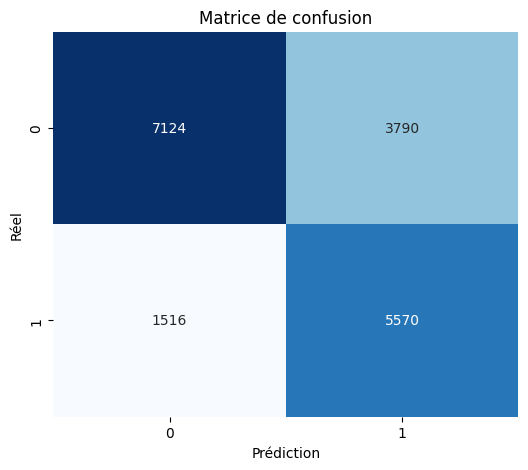

Modèle sauvegardé dans : ../models/Ml_model/model_xgb_pretri_with_early_stopping.joblib


In [ ]:
# Chargement des données
df_train = pd.read_csv("../data/Ml_data/train/dataset_train.csv")
df_test = pd.read_csv("../data/Ml_data/test/dataset_test.csv")

# Création de la feature dérivée co2_hygro_ratio
def compute_ratio(df):
    return df.apply(
        lambda row: row["co2"] / row["hygrometrie"] if pd.notnull(row["co2"]) and pd.notnull(row["hygrometrie"]) and row["hygrometrie"] != 0 else np.nan,
        axis=1
    )

df_test["co2_hygro_ratio"] = compute_ratio(df_test)
df_test["champ_substrat"] = df_test["champignon"] + "_" + df_test["substrat"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Création de la feature combinée champignon + substrat
df_train["champ_substrat"] = df_train["champignon"] + "_" + df_train["substrat"]
df_test["champ_substrat"] = df_test["champignon"] + "_" + df_test["substrat"]

# Séparation X / y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Colonnes catégorielles et numériques (avec la nouvelle feature combinée)
categorical_features = ["champignon", "substrat", "champ_substrat"]
numeric_features = ["Jour_inoculation", "hygrometrie", "co2", "co2_hygro_ratio"]

# Préprocessing
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
numeric_transformer = SimpleImputer(strategy="mean", add_indicator=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)
    ]
)

# Pipeline avec XGBoost (sans early stopping ici)
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        tree_method='hist',
        device='cuda',
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
        random_state=42
    ))
])

# Grille d'hyperparamètres
param_grid = {
    "classifier__n_estimators": [10, 20], # Nombre d'arbres
    "classifier__max_depth": [1, 3],# Profondeur maximale des arbres
    "classifier__learning_rate": [0.01],# Taux d'apprentissage
    "classifier__subsample": [0.8, 1.0],# Proportion d'échantillons pour chaque arbre
    "classifier__colsample_bytree": [0.8, 1.0],# Proportion de caractéristiques pour chaque arbre
    "classifier__min_child_weight": [1, 3],# Poids minimum de l'enfant
    "classifier__reg_alpha": [0, 0.1],# Pénalité L1
    "classifier__reg_lambda": [1, 1.5] # Pénalité L2
}

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

# Recherche hyperparamètres sans early stopping
grid_search.fit(X_train, y_train)

# Récupération du meilleur modèle pipeline
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score CV (F1) : {grid_search.best_score_:.3f}")

# Split validation pour early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

# Prétraitement manuel des données train et validation
X_train_sub_processed = best_model.named_steps['preprocessor'].transform(X_train_sub)
X_val_processed = best_model.named_steps['preprocessor'].transform(X_val)

# Préparation des DMatrix pour XGBoost natif
dtrain = xgb.DMatrix(X_train_sub_processed, label=y_train_sub)
dval = xgb.DMatrix(X_val_processed, label=y_val)

# Récupération et adaptation des paramètres du classifieur
params = best_model.named_steps['classifier'].get_xgb_params()
params.update({
    "tree_method": "hist",
    "device": "cuda",
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "scale_pos_weight": sum(y_train == 0) / sum(y_train == 1),
    "seed": 42
})

# Entraînement avec early stopping via API xgboost.train
evals = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=best_model.named_steps['classifier'].get_params()['n_estimators'],
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=False
)

# Remplacement du booster dans le classifieur pipeline par le booster natif entraîné
best_model.named_steps['classifier']._Booster = bst
best_model.named_steps['classifier']._le = None  # Reset label encoder interne

# Prétraitement du test
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)
dtest = xgb.DMatrix(X_test_processed)

# Prédiction avec booster natif
y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Évaluation
print(f"Accuracy test : {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# Sauvegarde du pipeline complet
model_dir = "../models/Ml_model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "model_xgb_pretri_with_early_stopping.joblib")
joblib.dump(best_model, model_path)
print(f"Modèle sauvegardé dans : {model_path}")

# test et validation du model


In [114]:
# Chemin vers le dossier des modèles
models_dir = "../models/Ml_model"

# Liste des fichiers modèles à tester (extension .joblib)
model_files = [f for f in os.listdir(models_dir) if f.endswith(".joblib")]

# Chargement du jeu de test
df_test = pd.read_csv("../data/Ml_data/test/dataset_test.csv")
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, labels, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

# Test de chaque modèle
for model_file in model_files:
    print(f"\n=== Test du modèle : {model_file} ===")
    
    # Chargement du modèle
    model_path = os.path.join(models_dir, model_file)
    model = joblib.load(model_path)
    
    # Prédiction (attention si modèle est un pipeline, sinon adapter)
    y_pred = model.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy : {accuracy:.3f}")
    
    # Rapport de classification
    report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print("\n📊 Rapport de classification :")
    display(report_df)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    labels = ["Inutile (0)", "À analyser (1)"]
    plot_confusion_matrix(cm, labels, model_file)


=== Test du modèle : model_xgb_pretri_with_early_stopping.joblib ===


ValueError: columns are missing: {'co2_hygro_ratio', 'champ_substrat'}